In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

(CVXPY) Apr 15 03:33:32 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [4]:
# Matrix shape and rank
n1, n2 = 100,100
k = 5
r = 3
prop_obs = 0.2
random_state = 1
allow_inf = False
alpha = 0.1

In [5]:
max_test_queries = 1000
sampler = QuerySampling(n1,n2)

# Split observation mask and test mask
mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [6]:
# Data model parameters
noise_model = "step"
mu = 10
gamma_n = 0.5
gamma_m = 0.9

# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

# Generate noise
nm = NoiseModel(random_state)
M = nm.get_noisy_matrix(M, gamma_n=gamma_n, gamma_m=gamma_m, model=noise_model, mu=mu, alpha=alpha, normalize=False)

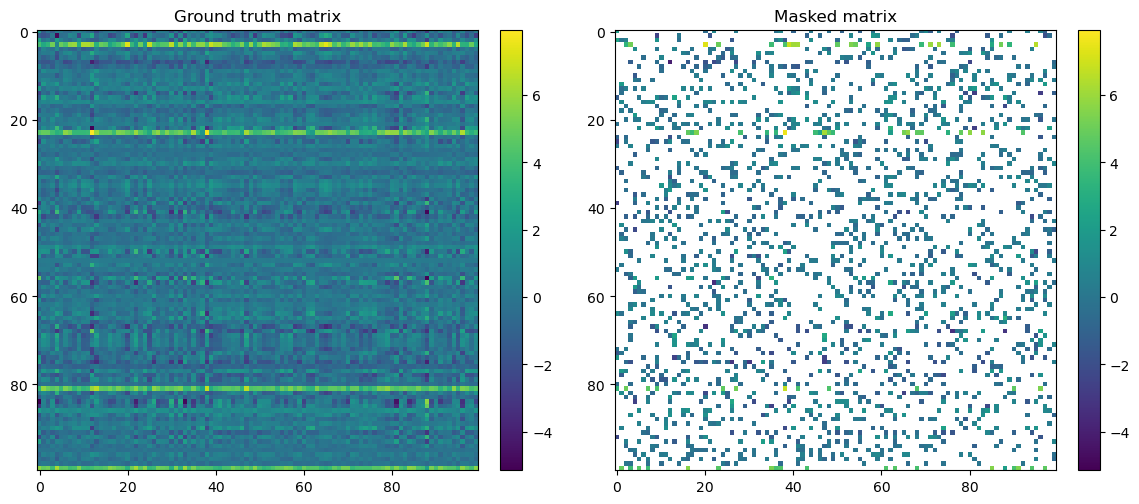

Missing entries are masked in white.


In [7]:
plot_before_after_mask(M, mask_obs,bad_color="white")
print("Missing entries are masked in white.")

# Simultaneous Conformal Inference

In [10]:
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 2000, training size: 1095,  calib queries: 181, test queries: 1000


In [ ]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)
#Mhat = svt_solve(M, mask_train, random_state=random_state)

Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0106
Iteration: 3; Mean diff: 0.0026
Iteration: 4; Mean diff: 0.0016
Iteration: 5; Mean diff: 0.0012
Iteration: 6; Mean diff: 0.0010
Iteration: 7; Mean diff: 0.0009
Iteration: 8; Mean diff: 0.0008
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0006
Iteration: 11; Mean diff: 0.0006
Iteration: 12; Mean diff: 0.0006
Iteration: 13; Mean diff: 0.0006
Iteration: 14; Mean diff: 0.0008
Iteration: 15; Mean diff: 0.0013
Iteration: 16; Mean diff: 0.0015
Iteration: 17; Mean diff: 0.0009
Iteration: 18; Mean diff: 0.0006
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0004
Iteration: 21; Mean diff: 0.0003
Iteration: 22; Mean diff: 0.0003
Iteration: 23; Mean diff: 0.0003
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0002
Iteration: 29; Mean diff: 0.0002
Iteration: 30; Mean diff: 0.0002
Iteration: 31; Mean

In [46]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k)
df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC")

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]

Done!


In [47]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.907,0.97,7.002114,0.0,SMC


# Bonferroni benchmark

In [48]:
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, 1, 
                                        calib_size=n_calib_queries*k, random_state=random_state)

print("Observation size: {}, training size: {}, calib size: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), len(idxs_test[0])//k))

Observation size: 2000, training size: 1095, calib size: 905, test queries: 1000


In [50]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0107
Iteration: 2; Mean diff: 0.0026
Iteration: 3; Mean diff: 0.0018
Iteration: 4; Mean diff: 0.0014
Iteration: 5; Mean diff: 0.0011
Iteration: 6; Mean diff: 0.0009
Iteration: 7; Mean diff: 0.0008
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0005
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0003
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0002
Iteration: 17; Mean diff: 0.0002
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 0.0001
Iteration: 30; Mean diff: 0.0001
Iteration: 31; Mean

In [51]:
a_list = [alpha, alpha * k]
ci_method = Bonf_benchmark(M, Mhat, mask_obs, idxs_calib, k)
df = ci_method.get_CI(idxs_test, a_list, allow_inf=allow_inf)
for i, m in enumerate(["Bonferroni", "Uncorrected"]):
    lower, upper, is_inf= df.loc[i].lower, df.loc[i].upper, df.loc[i].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method=m)])

Computing Bonferroni-style intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.51it/s]

Done!


In [52]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.907,0.9700,7.002114,0.0,SMC
0,0.961,0.9876,11.391882,0.0,Bonferroni
0,0.801,0.9300,4.329068,0.0,Uncorrected
